# Cyclist - Density Based Clustering (DBSCAN)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [1]:
%load_ext autoreload
%autoreload 2

!!! IMPORTANT !!!

This notebook, along with the notebooks ‘cyclist_density_based_clustering_3f.ipynb’ and ‘cyclist_density_based_clustering_4f.ipynb’ study the application of the DBSCAN density-based clustering algorithm. In particular, they represent three variants of our approach, aimed at studying the inclusion of more or fewer features in the clustering process.

The variant approach below includes in the clustering process the 5 features 'mean_bmi','mean_height', 'mean_cp' (climb power), 'mean_position' and 'mean_delta'.

The selection of these features was derived from a data understanding process, applied following the data cleaning and feature engeneering phases, through which it was possible to skim the attributes by identifying those that appeared to be the most significant.

In [2]:
import pandas as pd
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.cluster.hierarchy import fcluster

from scipy.spatial.distance import pdist, squareform
from kneed import KneeLocator

In [3]:
cyclists_dataset = pd.read_csv('../../data/cyclists_dataset_no_outliers.csv')
cyclists_dataset = cyclists_dataset.select_dtypes(include=['number'])
cyclists_dataset = cyclists_dataset.dropna().reset_index(drop=True)

cyclists_dataset.info()
columns_to_use = cyclists_dataset.columns

# Standardizzazione dei dati
scaler = StandardScaler()
data_scaled = scaler.fit_transform(cyclists_dataset)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2769 entries, 0 to 2768
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   mean_cyclist_cp  2769 non-null   float64
 1   mean_delta       2769 non-null   float64
 2   mean_position    2769 non-null   float64
 3   birth_year       2769 non-null   int64  
 4   weight           2769 non-null   float64
 5   height           2769 non-null   float64
 6   cyclist_bmi      2769 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 151.6 KB


Thanks to the following model selection process, the two parameters of the ‘DBSCAN’ algorithm (‘eps’ and ‘min_samples’) were selected in the context of this case study. Of the options studied in the process, the evaluation was made according to the trade-off between the number of clusters identified and silhouette score.

Each iteration of the model selection process starts with setting the ‘min_points’ parameter, studied in the range 2-20. For each of these alternatives, the optimal value of the ‘eps’ parameter is identified through the identification of the knee-point in the curve defined by the points (k-th distance, index).

Our Knee Method implementation:

- We compute the 𝑘-distance for each point:
    - Choose a value for 𝑘, a tipical choice should be to set to 𝑘 = min_points − 1, where min_points is the minimum number of points required to form a dense region (DBSCAN parameter fixed in the model selection iteration). 
    - For each point in the dataset, we calculate the distance to its 𝑘-th nearest neighbor (𝑘-distance).
- We sort the 𝑘-distances:
    - Arrange all the points by their 𝑘-distance in a 𝑘-distance plot, where the x-axis is the points (sorted) and the y-axis is their 𝑘-distance.
- Plot the 𝑘-distance graph
- Identify the "knee" in the plot: The y-axis typically increases gradually at first and then sharply increases, forming a curve. The knee corresponds to the point of maximum curvature in the graph. It is the location where the slope changes most significantly. Intuitively, it separates the "dense" regions (gradual slope) from the "sparse" regions (steep slope) in the dataset.


To automate the process of knee detection, we relied on the kneed library (KneeLocator).


#### Model Selection

In [4]:
dist = squareform(pdist(data_scaled, 'euclidean'))
min_points = range(2, 20)
optimal_eps = []
optimal_index = []
cluster_count = []
silhouette_scores = []



for i, value in enumerate(min_points):
    k = value - 1 #standard value? TODO: check this
    
    kth_distances = list()
    for d in dist:
        index_kth_distance = np.argsort(d)[k]
        kth_distances.append(d[index_kth_distance])

    sorted_distances = sorted(kth_distances)
    indices = range(0, len(kth_distances))

    # Use the KneeLocator to find the knee point
    kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")
    
    if(kneedle.knee is None):
        optimal_eps.append(None) 
        optimal_index.append(None)  
        silhouette_scores.append(None)
        continue
    
    # Get the knee (selecting automatically the optimal epsilon)
    optimal_eps.append(sorted_distances[kneedle.knee])  # The y-value at the knee
    optimal_index.append(kneedle.knee)  # The x-value (index)
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=optimal_eps[i], min_samples=value)
    clusters = dbscan.fit_predict(data_scaled)

    # Add cluster labels to the data
    cyclists_dataset['cluster'] = clusters
    number_of_clusters = cyclists_dataset['cluster'].nunique()
    cluster_count.append(number_of_clusters)
    
    if(number_of_clusters < 3): # Considering that a cluster (label -1) is that of outliers, to compute silhouette we need at least 3 clusters here
        silhouette_scores.append(None)
        continue
    
    # Removing outliers so to not include them in silhouette calculation
    no_out_data_scaled = scaler.fit_transform(cyclists_dataset[cyclists_dataset['cluster'] != -1])
    no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

    # Calculate Silhouette
    silhouette_scores.append(silhouette_score(no_out_data_scaled, no_out_labels))
    

# Creating the DataFrame
model_selection_data = {"min_points": min_points, "optimal_eps": optimal_eps, "optimal_index": optimal_index, "cluster_count": cluster_count, "silhouette_score": silhouette_scores}
model_selection_df = pd.DataFrame(model_selection_data)

model_selection_df

,min_points,optimal_eps,optimal_index,cluster_count,silhouette_score
0,2,1.580834,2757,4,0.801574
1,3,1.390773,2705,2,NaN
2,4,1.491498,2709,2,NaN
3,5,1.614535,2719,2,NaN
4,6,1.590448,2698,2,NaN
5,7,1.606036,2682,2,NaN
6,8,1.749491,2714,2,NaN
7,9,1.833731,2729,2,NaN
8,10,1.827288,2717,2,NaN
9,11,1.843776,2714,2,NaN


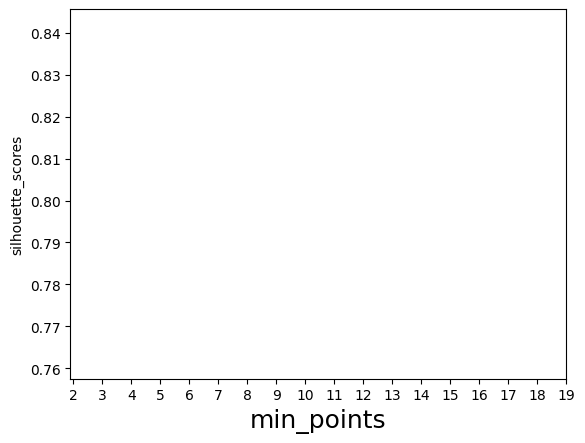

In [5]:
x = model_selection_df[model_selection_df['cluster_count'] > 2]['min_points']
y = model_selection_df[model_selection_df['cluster_count'] > 2]['silhouette_score']

plt.plot(x, y)
plt.ylabel('silhouette_scores')
plt.xlabel('min_points', fontsize=18)
plt.xticks(min_points)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.show()

#### Chosen Parameter Clustering

(3832296,)
(2769, 2769)
Optimal epsilon (eps): 1.491498437562475
Knee point index: 2709


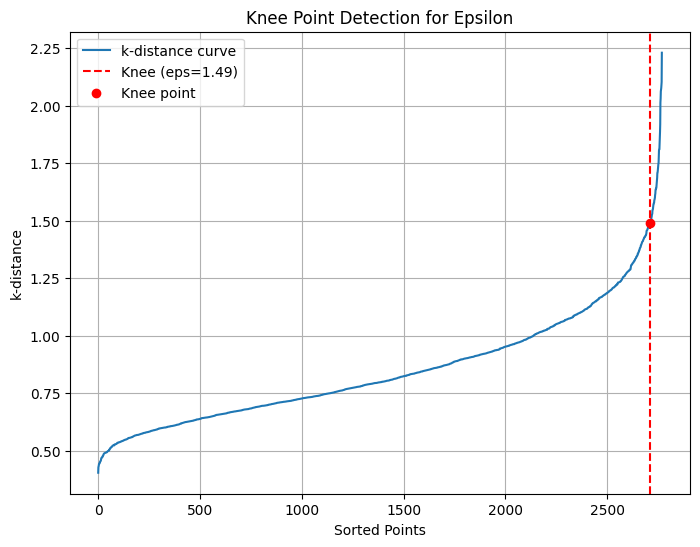

In [6]:
min_points = 4 # found throught model selection

dist = pdist(data_scaled, 'euclidean') #pair wise distance
print (dist.shape)
dist = squareform(dist) #distance matrix given the vector dist
print(dist.shape)

k = min_points - 1 #standard value?
kth_distances = list()
for d in dist:
    index_kth_distance = np.argsort(d)[k]
    kth_distances.append(d[index_kth_distance])

sorted_distances = sorted(kth_distances)
indices = range(0, len(kth_distances))

# Use the KneeLocator to find the knee point
kneedle = KneeLocator(indices, sorted_distances, curve="convex", direction="increasing")

# Get the knee (optimal epsilon)
optimal_eps = sorted_distances[kneedle.knee]  # The y-value at the knee
optimal_index = kneedle.knee  # The x-value (index)

print(f"Optimal epsilon (eps): {optimal_eps}")
print(f"Knee point index: {optimal_index}")

# Plot the k-distance graph with the knee point marked
plt.figure(figsize=(8, 6))
plt.plot(indices, sorted_distances, label="k-distance curve")
plt.axvline(optimal_index, linestyle="--", color="r", label=f"Knee (eps={optimal_eps:.2f})")
plt.scatter(optimal_index, optimal_eps, color="red", label="Knee point", zorder=5)
plt.xlabel("Sorted Points")
plt.ylabel("k-distance")
plt.title("Knee Point Detection for Epsilon")
plt.legend()
plt.grid()
plt.show()

#### Selection of best eps

In [7]:
# Apply DBSCAN
dbscan = DBSCAN(eps=optimal_eps, min_samples=min_points)
clusters = dbscan.fit_predict(data_scaled)

# Add cluster labels to the data
cyclists_dataset['cluster'] = clusters

# Display cluster distribution
print(cyclists_dataset['cluster'].value_counts())
print(cyclists_dataset.head())

cluster
 0    2746
-1      23
Name: count, dtype: int64
   mean_cyclist_cp  mean_delta  mean_position  birth_year  weight  height  \
0         0.000661  398.568966       0.707648        1951    77.0   186.0   
1         0.001823  847.935484       0.620541        1990    71.0   181.0   
2         0.003117  404.819672       0.467297        1983    73.0   181.0   
3         0.000033  458.285714       0.666310        1998    68.0   177.0   
4         0.000023  559.000000       0.828177        1997    68.0   181.0   

   cyclist_bmi  cluster  
0    22.256908        0  
1    21.672110        0  
2    22.282592        0  
3    21.705129        0  
4    20.756387        0  


In [8]:
np.unique(dbscan.labels_, return_counts=True)


(array([-1,  0]), array([  23, 2746]))

In [9]:
# Identify outliers (cluster label -1)
outliers = cyclists_dataset[cyclists_dataset['cluster'] == -1]
print("\nNumber of outliers:", len(outliers))


Number of outliers: 23


In [10]:
# Analyze the mean and standard deviation of numerical features for each cluster
cluster_stats = cyclists_dataset.groupby('cluster').agg(['mean', 'std'])
print("Cluster Statistics:\n", cluster_stats)

Cluster Statistics:
         mean_cyclist_cp            mean_delta             mean_position  \
                   mean       std        mean         std          mean   
cluster                                                                   
-1             0.004588  0.004107  397.854087  331.420872      0.642717   
 0             0.001657  0.001623  520.383645  208.464673      0.580344   

                    birth_year                weight                height  \
              std         mean        std       mean       std        mean   
cluster                                                                      
-1       0.186110  1974.826087  15.723902  67.869565  4.037375  177.217391   
 0       0.146411  1984.616169  10.727311  68.550947  5.677968  180.003642   

                  cyclist_bmi            
              std        mean       std  
cluster                                  
-1       5.089709   21.634194  1.414026  
 0       5.928043   21.140215  1.187896  


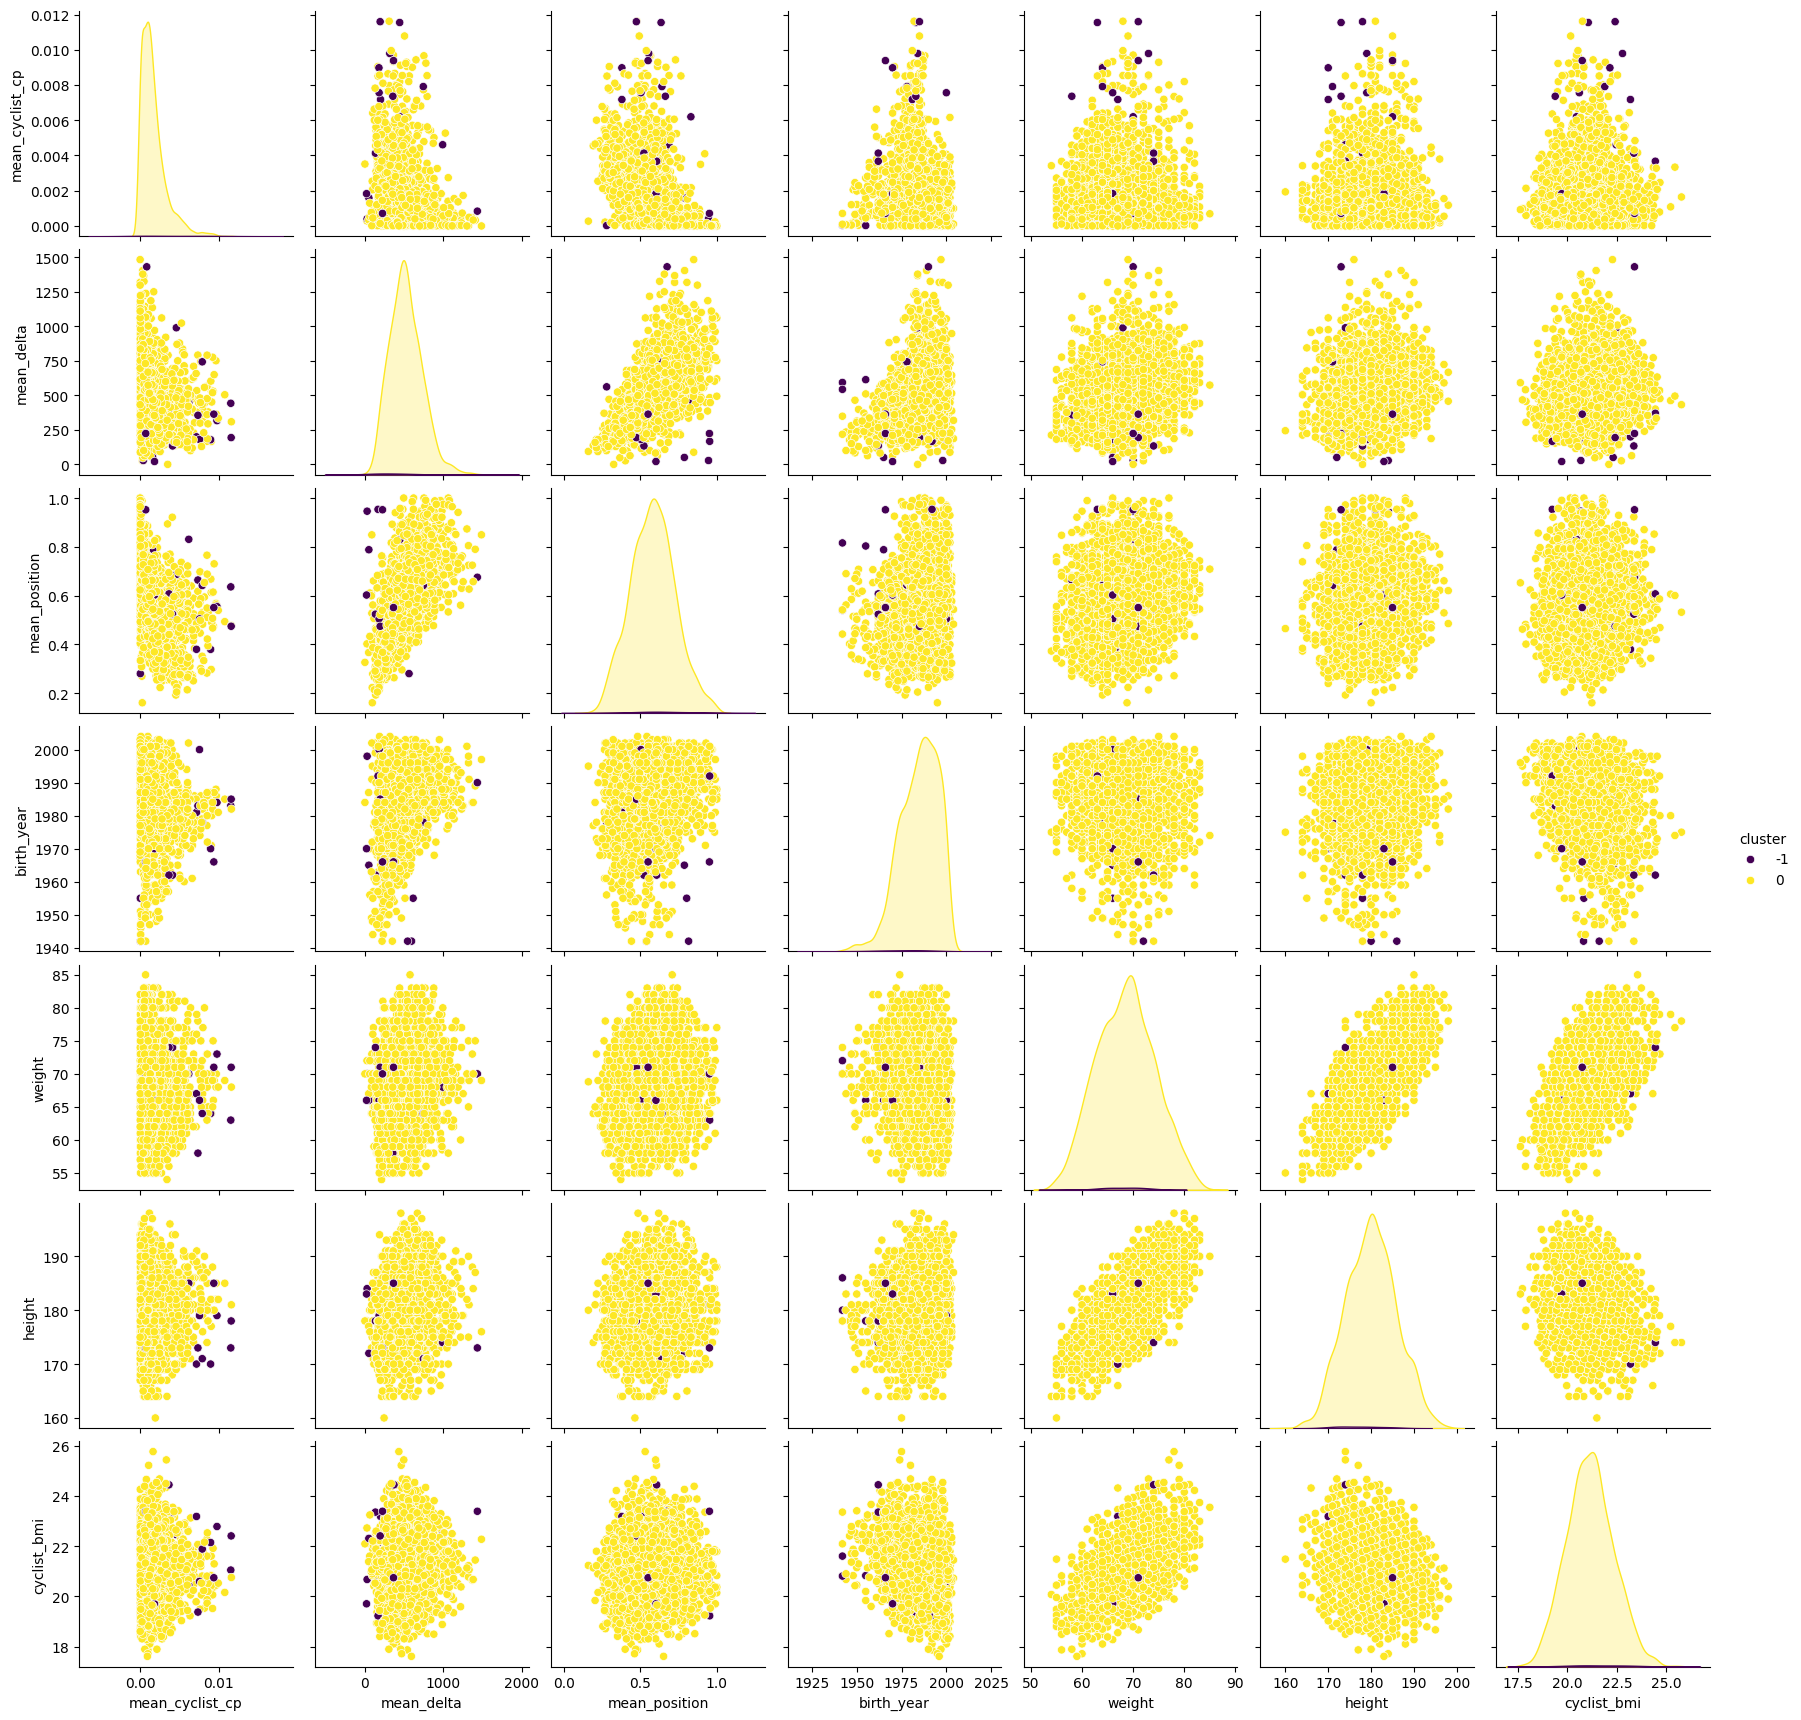

In [11]:
# Pair plot for a subset of columns
data_subset = cyclists_dataset[list(columns_to_use) + ["cluster"]]
sns.pairplot(data_subset, hue='cluster', palette='viridis')
plt.show()

In [ ]:
%matplotlib widget

x = cyclists_dataset['mean_bmi']  # Prima feature
y = cyclists_dataset['mean_position']  # Seconda feature
z = cyclists_dataset['mean_cp']  # Terza feature

# Crea il grafico 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatterplot
scatter = ax.scatter(x, y, z, c=cyclists_dataset['cluster'], cmap='viridis', s=50)
ax.set_xlabel('mean_bmi')
ax.set_ylabel('mean_position')
ax.set_zlabel('mean_cp')

# Aggiungi una legenda (opzionale)
legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
ax.add_artist(legend1)

plt.title('3D Scatterplot of Clusters')

# Abilita la modalità interattiva
plt.ion()
plt.show()

RuntimeError: 'widget is not a recognised GUI loop or backend name

Analyzing the clustering that involved all five features, we can observe how two clusters have been highlighted in the data. The larger cluster (in green in the plots) seems to represent the vast majority of cyclists, while those associated with the smaller cluster (yellow in the plots) seem to stand out for their average climbing power higher than the previous ones. No relevant associations seem to emerge between the clusters identified by the algorithm and the other features, so we proceed with the analyses of the notebooks "cyclist_density_based_clustering_4f" and "cyclist_density_based_clustering_3f", where we reduce the features to those that from these results seem to be more influential in a possible clustering (observing the distribution of the data in space). We then eliminate the feature "height" (analysis in the notebook "cyclist_density_based_clustering_4f").

In [13]:
data_scaled = scaler.fit_transform(cyclists_dataset[cyclists_dataset['cluster'] != -1])
no_out_labels = dbscan.labels_[dbscan.labels_ != -1]

print('Silhouette %s' % silhouette_score(data_scaled, no_out_labels))

ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)